In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [2]:
# Load previously generated synthetic LC-MS grid from JSON
gaussians_grid = pd.read_json(r"C:\Users\victo\VSCode Folder\mass_spec_project\data\json\gaussians_grid.json")
print(gaussians_grid.head())

          rt                                                 mz  \
0  10.000000  [150, 150.0107917936, 150.0214675712, 150.0317...   
1  10.049022  [150, 150.0103545134, 150.0202744958, 150.0310...   
2  10.094543  [150, 150.0094729806, 150.0200318702, 150.0293...   
3  10.148506  [150, 150.0094058632, 150.0193528758, 150.0290...   
4  10.200007  [150, 150.009180935, 150.0198344818, 150.02974...   

                                         intensities  
0  [0.2197366292, 0.0, 0.0, 0.0, 0.0, 0.255882325...  
1  [0.1893830283, 0.0, 0.22610833530000002, 0.0, ...  
2  [0.11031056560000001, 0.2135564623, 0.0, 0.0, ...  
3  [0.5515372042000001, 0.7604282633, 0.616124777...  
4  [0.0215221041, 0.0, 0.0293257152, 0.0, 0.06009...  


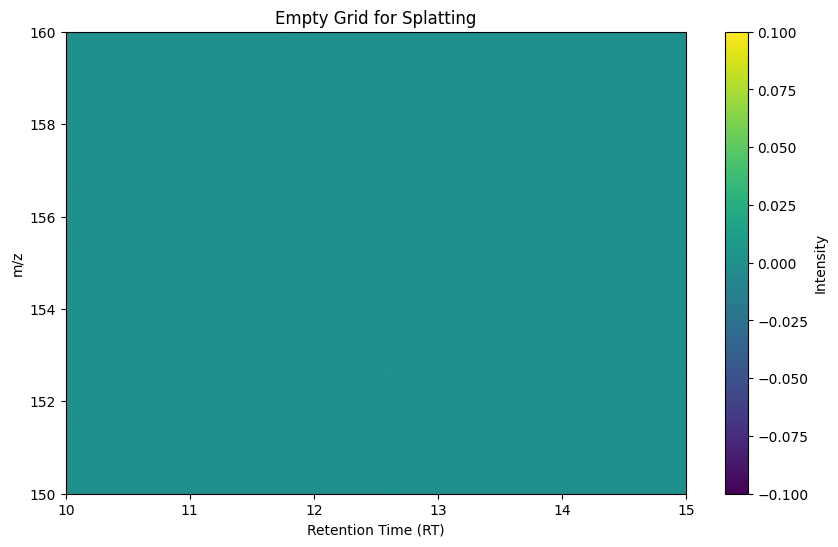

In [3]:
# Define regular sampling axes for splatting
rt_axis = np.linspace(10, 15, 100)  # 100 RT points between 10 and 15 min
mz_axis = np.linspace(150, 160, 1000)  # 1000 m/z points between 150 and 160 Da

# Create an empty grid of zeros (m/z × RT)
X, Y = np.meshgrid(rt_axis, mz_axis)
grid = np.zeros_like(X)


# Quick visualization: Empty grid (all zeros)
plt.figure(figsize=(10, 6))
plt.imshow(grid, aspect='auto', extent=[rt_axis.min(), rt_axis.max(), mz_axis.min(), mz_axis.max()],
           origin='lower', cmap='viridis')
plt.xlabel('Retention Time (RT)')
plt.ylabel('m/z')
plt.title('Empty Grid for Splatting')
plt.colorbar(label='Intensity')
plt.show()

In [4]:
# Splat (bin) the loaded sparse data into the regular grid
for _, row in gaussians_grid.iterrows():
    rt = row['rt'] # Retention Time
    mz_values = row['mz'] # List of m/z points
    intensity_values = row['intensities'] # Corresponding intensity values
    
    # Find nearest RT index
    rt_idx = np.abs(rt_axis - rt).argmin()
    
    for mz, intensity in zip(mz_values, intensity_values):
        # Find nearest m/z index
        mz_idx = np.abs(mz_axis - mz).argmin()
        # Add intensity into the corresponding grid bin
        grid[mz_idx, rt_idx] += intensity  # hard binning

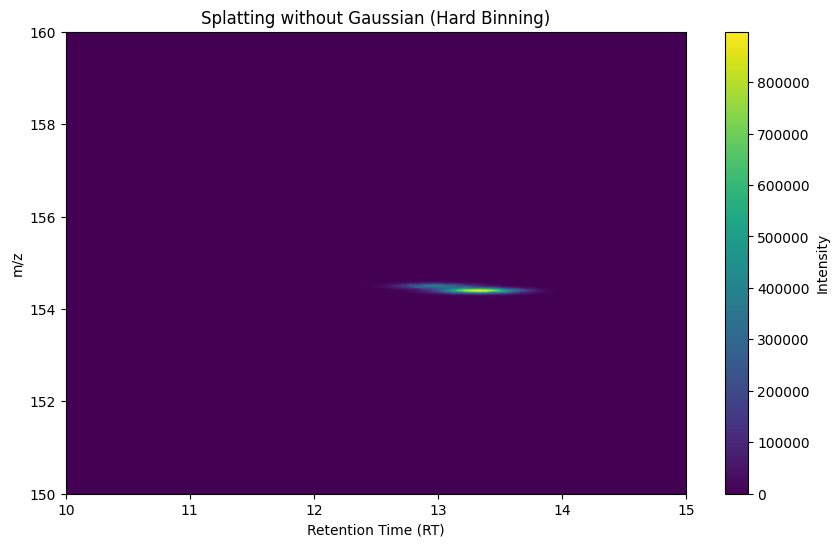

In [5]:
# Plot the splatted grid (post-splatting)
plt.figure(figsize=(10, 6))
plt.imshow(grid, aspect='auto', extent=[rt_axis.min(), rt_axis.max(), mz_axis.min(), mz_axis.max()],
           origin='lower', cmap='viridis')
plt.xlabel('Retention Time (RT)')
plt.ylabel('m/z')
plt.title('Splatting without Gaussian (Hard Binning)')
plt.colorbar(label='Intensity')
plt.show()


In [6]:
import numpy as np
from scipy.ndimage import gaussian_filter

# --- Smooth the Grid First
smoothed_grid = gaussian_filter(grid, sigma=1)  # small smoothing

# --- First Derivatives
d_grid_mz = np.diff(smoothed_grid, axis=0)
d_grid_rt = np.diff(smoothed_grid, axis=1)

# --- Second Derivatives
dd_grid_mz = np.diff(d_grid_mz, axis=0)
dd_grid_rt = np.diff(d_grid_rt, axis=1)

In [7]:
def find_next_active_box(grid, processed_mask, mz_axis, rt_axis, 
                          global_intensity_thresh=0.01, local_margin=2):
    """
    Find the next active (non-processed, strong) region and grow a box around it.
    
    Parameters:
        grid (2D array): Smoothed intensity grid (m/z × RT)
        processed_mask (2D array): Boolean mask indicating already processed areas
        mz_axis (1D array): m/z values corresponding to grid rows
        rt_axis (1D array): RT values corresponding to grid columns
        global_intensity_thresh (float): Global intensity cutoff for "active" signal
        local_margin (int): Margin to pad around detected active region
    
    Returns:
        box (dict): {'mz_min', 'mz_max', 'rt_min', 'rt_max'} or None if no region found
    """

    global_max = np.max(grid)
    cutoff = global_max * global_intensity_thresh

    active_mask = (grid > cutoff) & (processed_mask == 'unprocessed')


    mz_bins, rt_bins = active_mask.shape

    # Find first unprocessed active pixel
    found = np.argwhere(active_mask)
    if found.size == 0:
        return None  # No more active regions

    start_mz_idx, start_rt_idx = found[0]

    # Grow the box starting from this point
    mz_min_idx, mz_max_idx, rt_min_idx, rt_max_idx = grow_box_from_start(
        active_mask, start_mz_idx, start_rt_idx
    )

    # Apply local margin
    mz_min_idx = max(mz_min_idx - local_margin, 0)
    mz_max_idx = min(mz_max_idx + local_margin, mz_bins - 1)
    rt_min_idx = max(rt_min_idx - local_margin, 0)
    rt_max_idx = min(rt_max_idx + local_margin, rt_bins - 1)

    # Build box
    box = {
        'mz_min': mz_axis[mz_min_idx],
        'mz_max': mz_axis[mz_max_idx],
        'rt_min': rt_axis[rt_min_idx],
        'rt_max': rt_axis[rt_max_idx],
        'mz_min_idx': mz_min_idx,
        'mz_max_idx': mz_max_idx,
        'rt_min_idx': rt_min_idx,
        'rt_max_idx': rt_max_idx
    }

    return box


def grow_box_from_start(active_mask, start_mz_idx, start_rt_idx):
    """
    Expand a bounding box from a starting active pixel using simple flood-fill.
    """

    mz_bins, rt_bins = active_mask.shape
    visited = np.zeros_like(active_mask, dtype=bool)
    to_visit = [(start_mz_idx, start_rt_idx)]

    mz_min_idx = mz_max_idx = start_mz_idx
    rt_min_idx = rt_max_idx = start_rt_idx

    while to_visit:
        mz_idx, rt_idx = to_visit.pop()

        if (mz_idx < 0 or mz_idx >= mz_bins or
            rt_idx < 0 or rt_idx >= rt_bins or
            visited[mz_idx, rt_idx] or
            not active_mask[mz_idx, rt_idx]):
            continue  # Skip

        visited[mz_idx, rt_idx] = True

        mz_min_idx = min(mz_min_idx, mz_idx)
        mz_max_idx = max(mz_max_idx, mz_idx)
        rt_min_idx = min(rt_min_idx, rt_idx)
        rt_max_idx = max(rt_max_idx, rt_idx)

        # Add neighbors to check
        neighbors = [
            (mz_idx-1, rt_idx), (mz_idx+1, rt_idx),
            (mz_idx, rt_idx-1), (mz_idx, rt_idx+1)
        ]
        to_visit.extend(neighbors)

    return mz_min_idx, mz_max_idx, rt_min_idx, rt_max_idx

In [8]:
def crop_box(grid, mz_axis, rt_axis, box):
    """
    Extract a cropped version of the grid and axes inside a given box.
    
    Returns:
        cropped_grid, cropped_mz_axis, cropped_rt_axis
    """
    mz_slice = slice(box['mz_min_idx'], box['mz_max_idx'] + 1)
    rt_slice = slice(box['rt_min_idx'], box['rt_max_idx'] + 1)
    
    cropped_grid = grid[mz_slice, rt_slice]
    cropped_mz_axis = mz_axis[mz_slice]
    cropped_rt_axis = rt_axis[rt_slice]
    
    return cropped_grid, cropped_mz_axis, cropped_rt_axis

def mark_box(processed_mask, box, label):
    """
    Mark a given box inside the processed_mask array with a label ('singular' or 'overlapping').
    """
    mz_slice = slice(box['mz_min_idx'], box['mz_max_idx'] + 1)
    rt_slice = slice(box['rt_min_idx'], box['rt_max_idx'] + 1)
    
    processed_mask[mz_slice, rt_slice] = label


In [9]:
def estimate_peak_widths(grid, mz_axis, relative_threshold=0.05) -> np.array:
    """
    Estimate peak widths across RT by using a fixed intensity threshold.
    
    Parameters:
        grid (2D np.array): Smoothed intensity grid (m/z × RT)
        mz_axis (1D np.array): Array of m/z values corresponding to grid rows
        relative_threshold (float): Fraction of global maximum intensity to define peak region
    
    Returns:
        np.array: Array of peak widths (in m/z units) per RT column
    """
    # Initialize empty widths array (one width per RT point)
    widths = np.zeros(grid.shape[1])
    
    # Find the global maximum intensity in the entire grid
    global_max = np.max(grid)
    cutoff = global_max * relative_threshold
    
    # Loop over each RT point (each column in the grid)
    for j in range(grid.shape[1]):
        column = grid[:, j]

        # Find all m/z indices where intensity is above cutoff
        indices_above_cutoff = np.where(column >= cutoff)[0]
        
        if len(indices_above_cutoff) > 1:
            # Calculate width as m/z difference between last and first above-threshold point
            width = mz_axis[indices_above_cutoff[-1]] - mz_axis[indices_above_cutoff[0]]
            widths[j] = width
        else:
            # Not enough points above threshold ➔ No meaningful peak width
            widths[j] = 0
    
    return widths

def check_width_growth(peak_widths, threshold=0.2):
    """
    Detect sudden increases in peak width over adjacent RT indices.
    """
    width_diff = np.diff(peak_widths)
    growth_mask = width_diff > (threshold * np.maximum(peak_widths[:-1], 1e-6))
    return np.concatenate([growth_mask, [False]])

def check_slope_anomaly(grid, threshold=0.5):
    """
    Detect unusually steep changes in signal intensity (1st derivative).
    """
    d_grid_rt = np.diff(grid, axis=1)
    d_grid_rt_1d = np.max(np.abs(d_grid_rt), axis=0)
    max_slope = np.max(d_grid_rt_1d)
    anomaly_mask = d_grid_rt_1d > (threshold * max_slope)
    return np.concatenate([anomaly_mask, [False]])

def check_curvature_flatness(grid, threshold=0.2, width_gate=None):
    """
    Detect flattening of curvature (2nd derivative) gated by peak width to suppress noise.
    """
    d_grid_rt = np.diff(grid, axis=1)
    dd_grid_rt = np.diff(d_grid_rt, axis=1)
    dd_grid_rt_1d = np.max(np.abs(dd_grid_rt), axis=0)
    max_curvature = np.max(dd_grid_rt_1d)
    flat_mask_raw = dd_grid_rt_1d < (threshold * max_curvature)
    
    if width_gate is not None:
        width_gate = width_gate[:-2]  # align due to 2 diffs
        flat_mask = flat_mask_raw[:len(width_gate)] & (width_gate > 0.01)
        return np.concatenate([flat_mask, [False, False]])
    else:
        return np.concatenate([flat_mask_raw, [False, False]])

In [10]:
def group_suspicious_zones(suspicious_mask, min_zone_size=3, merge_gap=2):
    """
    Group consecutive suspicious points into zones.
    Optionally merge zones if they are close together.
    
    Parameters:
        suspicious_mask (np.array): Boolean array where True = suspicious.
        min_zone_size (int): Minimum size of a valid suspicious zone.
        merge_gap (int): Maximum gap between zones to auto-merge.

    Returns:
        List of tuples: (start_index, end_index)
    """
    zones = []
    start_idx = None # Keeps track of where a suspicious zone starts

    # Step 1: Identify raw suspicious zones
    for i, val in enumerate(suspicious_mask):
        if val and start_idx is None:
            # Start of a new suspicious zone
            start_idx = i
        elif not val and start_idx is not None:
            # End of a suspicious zone
            if (i - start_idx) >= min_zone_size:
                zones.append((start_idx, i - 1))
            start_idx = None # Reset

    # Step 2: Merge nearby zones if gap is small enough
    if start_idx is not None and (len(suspicious_mask) - start_idx) >= min_zone_size:
        zones.append((start_idx, len(suspicious_mask) - 1))

    # Merge zones that are very close
    if merge_gap > 0 and len(zones) > 1:
        merged_zones = []
        current_start, current_end = zones[0]

        for next_start, next_end in zones[1:]:
            if next_start - current_end <= merge_gap:
                # Zones are close enough ➔ Merge
                current_end = next_end
            else:
                # Zones are too far apart ➔ Save current zone and move on
                merged_zones.append((current_start, current_end))
                current_start, current_end = next_start, next_end

        # Add last zone
        merged_zones.append((current_start, current_end))
        zones = merged_zones

    return zones

In [11]:
def plot_zones_over_width(peak_widths, zones, title="Suspicious Zones over Width Curve"):
    """
    Plot peak width curve across RT and shade detected suspicious zones.

    Parameters:
        peak_widths (np.array): Array of estimated peak widths vs RT index.
        zones (List[Tuple[int, int]]): List of (start, end) RT index ranges for suspicious zones.
        title (str): Title for the plot.
    """
    plt.figure(figsize=(14,6))
    # Plot the base peak width curve
    plt.plot(peak_widths, label='Estimated Peak Width', color='black')

    # Shade suspicious zones
    for (start, end) in zones:
        plt.axvspan(start, end, color='red', alpha=0.3)

    plt.xlabel('RT Index')
    plt.ylabel('Width (m/z units)')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_suspicious_signals(peak_widths, width_growth, slope_anomaly, curvature_flat, suspicious_mask):
    """
    Plot diagnostic subplots for each suspicious signal detection method.
    
    Parameters:
        peak_widths (np.array): Estimated peak widths vs RT index.
        width_growth (np.array): Boolean mask of width expansion.
        slope_anomaly (np.array): Boolean mask of slope anomalies.
        curvature_flat (np.array): Boolean mask of flat curvature.
        suspicious_mask (np.array): Combined suspicious signal mask.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

    axes[0].plot(peak_widths, label='Width')
    axes[0].plot(np.where(width_growth, peak_widths, np.nan), 'ro', label='Width Growth')
    axes[0].legend()
    axes[0].set_title('Width Growth Check')

    axes[1].plot(peak_widths, label='Width')
    axes[1].plot(np.where(slope_anomaly, peak_widths, np.nan), 'go', label='Slope Anomalies')
    axes[1].legend()
    axes[1].set_title('Slope Anomaly Check')

    axes[2].plot(peak_widths, label='Width')
    axes[2].plot(np.where(curvature_flat, peak_widths, np.nan), 'bo', label='Curvature Flattening')
    axes[2].legend()
    axes[2].set_title('Curvature Flattening Check')

    axes[3].plot(peak_widths, label='Width')
    axes[3].plot(np.where(suspicious_mask, peak_widths, np.nan), 'mo', label='Suspicious Points')
    axes[3].legend()
    axes[3].set_title('Combined Suspicious Points')

    plt.tight_layout()
    plt.show()


In [12]:
def detect_suspicious(grid, mz_axis, width_cutoff=0.02, plot=True, min_zone_size=3, merge_gap=2):
    """
    High-level check if a region is suspicious based on signal anomalies.
    
    Parameters:
        grid (2D array): The cropped intensity grid for a specific region.
        mz_axis (1D array): Corresponding m/z axis for the grid.
        width_cutoff (float): Threshold for determining signal region in width estimation.
        plot (bool): Whether to generate plots of the signal analysis.
        min_zone_size (int): Minimum size of a suspicious region to count.
        merge_gap (int): Merge nearby suspicious zones if gap is smaller than this.

    Returns:
        bool: True if suspicious zones are found, otherwise False.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    peak_widths = estimate_peak_widths(grid, mz_axis, relative_threshold=width_cutoff)
    width_growth = check_width_growth(peak_widths)
    slope_anomaly = check_slope_anomaly(grid)
    curvature_flat = check_curvature_flatness(grid, width_gate=peak_widths)

    suspicious_mask = width_growth | slope_anomaly | curvature_flat
    
    # COULD REPLACE WITH A VOTING SYSTEM
    suspicious = np.any(suspicious_mask)

    if plot:
        plot_suspicious_signals(peak_widths, width_growth, slope_anomaly, curvature_flat, suspicious_mask)
        zones = group_suspicious_zones(suspicious_mask, min_zone_size=min_zone_size, merge_gap=merge_gap)
        plot_zones_over_width(peak_widths, zones, title="Suspicious Zones over Width Curve")

    return suspicious


In [13]:
def plot_box_on_grid(grid, box, mz_axis, rt_axis, title="Detected Box on Intensity Grid"):
    """
    Plot the full grid and overlay the detected box region.

    Parameters:
        grid (2D array): Full intensity grid.
        box (dict): Dictionary with 'mz_min_idx', 'mz_max_idx', 'rt_min_idx', 'rt_max_idx'.
        mz_axis (1D array): m/z axis values.
        rt_axis (1D array): Retention time axis values.
        title (str): Plot title.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    extent = [rt_axis[0], rt_axis[-1], mz_axis[0], mz_axis[-1]]
    
    # Plot the full grid
    img = ax.imshow(grid, 
                    extent=extent, 
                    aspect='auto', 
                    origin='lower', 
                    cmap='viridis')

    # Extract box boundaries
    mz_min = mz_axis[box['mz_min_idx']]
    mz_max = mz_axis[box['mz_max_idx']]
    rt_min = rt_axis[box['rt_min_idx']]
    rt_max = rt_axis[box['rt_max_idx']]
    
    # Draw box as a red rectangle
    rect = plt.Rectangle((rt_min, mz_min), rt_max - rt_min, mz_max - mz_min,
                         linewidth=2, edgecolor='red', facecolor='none', label='Detected Box')
    ax.add_patch(rect)

    plt.colorbar(img, ax=ax, label='Intensity')
    ax.set_xlabel('Retention Time (RT)')
    ax.set_ylabel('m/z')
    ax.set_title(title)
    ax.legend()
    plt.grid(False)
    plt.show()




In [22]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

def run_3d_dbscan(cropped_grid, rt_axis, mz_axis,
                  eps=0.4, min_samples=3,
                  intensity_thresh_ratio=0.05,
                  plot=False):
    threshold = np.max(cropped_grid) * intensity_thresh_ratio
    points = []

    for mz_idx, mz in enumerate(mz_axis):
        for rt_idx, rt in enumerate(rt_axis):
            intensity = cropped_grid[mz_idx, rt_idx]
            if intensity >= threshold:
                points.append([rt, mz, intensity])

    if not points:
        return np.array([])

    points = np.array(points)

    # --- Normalize features (very important!)
    scaler = StandardScaler()
    points_scaled = scaler.fit_transform(points)

    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(points_scaled)

    if plot:
        _plot_3d_dbscan(points, labels)

    return labels


def _plot_3d_dbscan(points, labels):
    """
    3D plot for DBSCAN clusters over (RT, m/z, intensity).
    """
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    import numpy as np

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    unique_labels = set(labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

    for i, label in enumerate(unique_labels):
        mask = (labels == label)
        cluster_points = points[mask]
        color = 'k' if label == -1 else colors[i]

        ax.scatter(cluster_points[:, 0],  # RT
                   cluster_points[:, 1],  # m/z
                   cluster_points[:, 2],  # intensity
                   c=[color], label=f'{"Noise" if label==-1 else f"Cluster {label}"}',
                   s=15, alpha=0.8)

    ax.set_xlabel("RT")
    ax.set_ylabel("m/z")
    ax.set_zlabel("Intensity")
    ax.set_title("3D DBSCAN Clustering")
    ax.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
from lmfit.models import GaussianModel
from lmfit import Parameters

def grid_to_point_cloud(grid, rt_axis, mz_axis, intensity_thresh_ratio=0.05):
    """
    Convert a cropped RT × m/z intensity grid to a list of (rt, mz, intensity) points.
    Filters out low-intensity points.
    """
    points = []
    threshold = np.max(grid) * intensity_thresh_ratio

    for mz_idx, mz in enumerate(mz_axis):
        for rt_idx, rt in enumerate(rt_axis):
            intensity = grid[mz_idx, rt_idx]
            if intensity >= threshold:
                points.append([rt, mz, intensity])
    
    return np.array(points)

def fit_single_gaussian(points):
    """
    Fit a 2D Gaussian (RT, m/z) to the intensity point cloud.
    """
    rt, mz, intensity = points[:, 0], points[:, 1], points[:, 2]

    # We'll fit intensity as a function of RT (x) and m/z (y)
    # Trick: Flatten as 1D curve by combining RT and m/z into a single axis
    xdata = np.column_stack([rt, mz])

    # Use lmfit's custom modeling for 2D Gaussian
    def gaussian_2d(params, xdata):
        x, y = xdata[:, 0], xdata[:, 1]
        amp = params['amp']
        x0 = params['x0']
        y0 = params['y0']
        sigma_x = params['sigma_x']
        sigma_y = params['sigma_y']
        return amp * np.exp(-((x - x0)**2 / (2 * sigma_x**2) + (y - y0)**2 / (2 * sigma_y**2)))

    def residual(params, xdata, data):
        return gaussian_2d(params, xdata) - data

    # Initial guesses
    params = Parameters()
    params.add('amp', value=np.max(intensity))
    params.add('x0', value=np.mean(rt))
    params.add('y0', value=np.mean(mz))
    params.add('sigma_x', value=np.std(rt))
    params.add('sigma_y', value=np.std(mz))

    from lmfit.minimizer import minimize
    result = minimize(residual, params, args=(xdata, intensity))

    return result


Suspicious: True


Running Micro DBSCAN


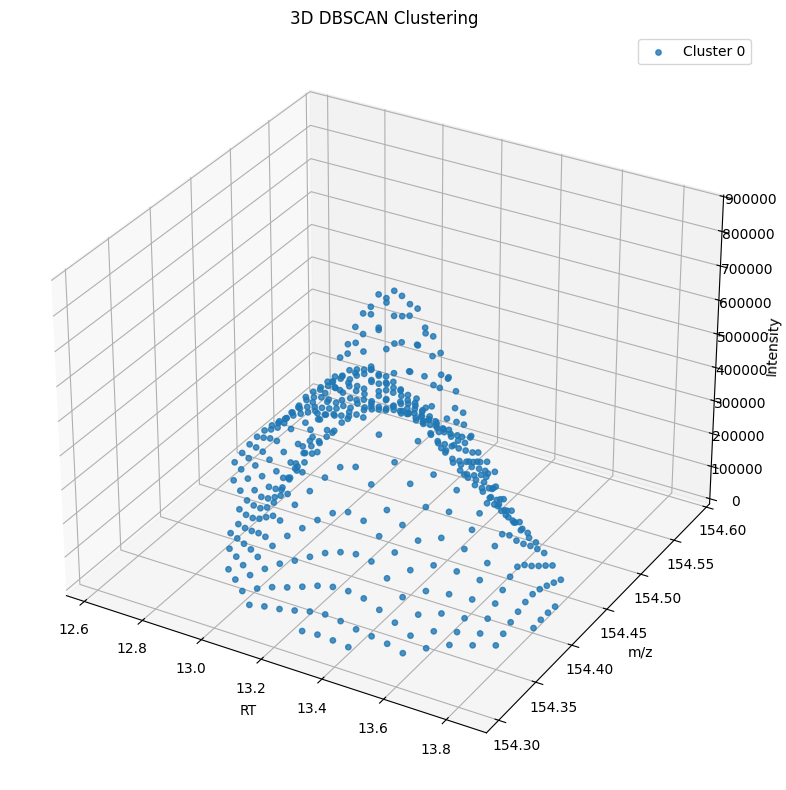

Total boxes found: 1


In [23]:
# MAIN LOOP

# Initialize label grid
processed_mask = np.full_like(grid, fill_value='unprocessed', dtype=object)
all_boxes = []
suspicious_boxes = []

# Main Processing Loop
while 'unprocessed' in processed_mask:
    # 1. Find next box
    box = find_next_active_box(smoothed_grid, processed_mask, mz_axis, rt_axis, global_intensity_thresh=0.001)
#    if box:
#         plot_box_on_grid(smoothed_grid, box, mz_axis, rt_axis)
    if box is None:
        break  # No more active regions
    
        # 2. Save box
    all_boxes.append(box)

    # 3. Crop region from grid
    cropped_grid, cropped_mz_axis, cropped_rt_axis = crop_box(smoothed_grid, mz_axis, rt_axis, box)

    # 4. Run suspicious signal detection
    is_suspicious = detect_suspicious(cropped_grid, cropped_mz_axis, plot=False)
    print(f"Suspicious: {is_suspicious}")

    # 5. Mark box based on result
    if is_suspicious:
        mark_box(processed_mask, box, label='suspicious')
        suspicious_boxes.append(box)
        next_action = input(f"Suspicious boxes found: {len(suspicious_boxes)}. Continue? (y/n): ").strip().lower()
        if next_action in ['y', 'yes']:
            print("Running Micro DBSCAN")
            labels = run_3d_dbscan(cropped_grid, cropped_rt_axis, cropped_mz_axis, plot=True)



    else:
        mark_box(processed_mask, box, label='singular')

# 6. Summary
print(f"Total boxes found: {len(all_boxes)}")

| Plot | What We Test | What It Catches | When It Triggers |
|:-----|:-------------|:----------------|:----------------|
| Plot 1 (Red) | Sudden width expansion | Early peak growth | If width grows too fast between neighboring RT points. |
| Plot 2 (Green) | Slope anomalies | Top of peak | If slope behavior becomes too sharp or irregular. |
| Plot 3 (Blue) | Curvature flattening | Top and sides of peak | If the peak top becomes too flat (less pointy). |
| Plot 4 (Magenta) | Combination | Everything flagged | If any of the three features say "suspicious". |
